In [52]:
# https://sourceforge.net/p/rdkit/mailman/message/34922663/ procedure extracted from this support request
# https://pschmidtke.github.io/blog/rdkit/3d-editor/2021/01/23/grafting-fragments.html
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True 
import py3Dmol
from rdkit.Chem import AllChem
import copy
from rdkit.Chem.rdMolAlign import AlignMol

In [69]:
# Protonate ligand
# Note use of pH=7 to stop adding H atom to acid group

!babel -isdf in.sdf -osdf in_h.sdf -h -p 7

1 molecule converted
43 audit log messages 


In [70]:
suppl = Chem.SDMolSupplier('in_h.sdf',removeHs=False)
suppl

In [55]:
# Check 3D structure, and protonation

for mol in suppl:
    mblock = Chem.MolToMolBlock(mol)
viewer = py3Dmol.view(width=300, height=300)
viewer.addModel(mblock, 'mol')
viewer.setStyle({"stick":{}})
viewer.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

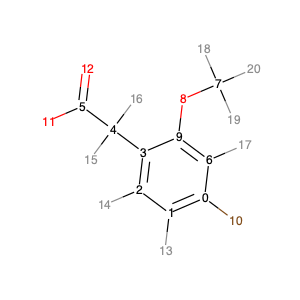

In [71]:
# Display atom numbers

for atom in mol.GetAtoms():
    atom.SetAtomMapNum(atom.GetIdx())
mol2d=copy.deepcopy(mol)
AllChem.Compute2DCoords(mol2d)    #do this on a copy here

Draw.MolToImage(mol2d, includeAtomNumbers=True)

In [72]:
def getAttachmentVector(mol):
    """ for a fragment to add, search for the position of 
    the attachment point and extract the atom id's of the 
    attachment point and the connected atom 
    (currently only single bond supported)
    mol: fragment passed as rdkit molecule
    return: tuple (atom indices)
    """

    rindex=-1
    rindexNeighbor=-1
    for atom in mol.GetAtoms():
        if(atom.GetAtomicNum()==0):
            rindex=atom.GetIdx()
            neighbours=atom.GetNeighbors()
            if(len(neighbours)==1):
                rindexNeighbor=neighbours[0].GetIdx()
            else: 
                print("two attachment points not supported yet")
                return None
    return((rindex,rindexNeighbor))

In [73]:
# Tutorial suggest this library of fragments: 
# https://github.com/openchemistry/molecules
# But for methane, I drew it in Avogadro and exported as mol file
# Importantly, connection point can be defined by changing H to R
# in element column.

fragment=Chem.MolFromMolFile('methyl.mol',removeHs=False)
ret=getAttachmentVector(fragment)

for atom in mol.GetAtoms():
    atom.SetAtomMapNum(atom.GetIdx())
if(ret):
    fragIndex1,fragIndex2=ret

print(fragIndex1, fragIndex2)
mblock = Chem.MolToMolBlock(fragment)
viewer = py3Dmol.view(width=300, height=300)
viewer.addModel(mblock, 'mol')
viewer.setStyle({"stick":{}})
viewer.zoomTo()

4 0


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [74]:
fragment=Chem.MolFromMolFile('methyl.mol',removeHs=False)
print(fragment.GetNumAtoms())

5


In [75]:
# Select atom index on parent to grow from
# See atom numbering above

queryAtomIndex=17

atom=mol.GetAtomWithIdx(queryAtomIndex)
neighbours=atom.GetNeighbors()
if(len(neighbours)==1):
    rindexNeighbor=neighbours[0].GetIdx()
else: 
    print("two attachment points not supported yet")
    
molIndex1=queryAtomIndex
molIndex2=rindexNeighbor
print(molIndex1,molIndex2)

17 6


In [76]:
#important to specify the atomMap here, this aligns only the bonds

AlignMol(fragment,mol,atomMap=((fragIndex2,molIndex1),(fragIndex1,molIndex2)))

0.019000616019482355

In [77]:
#the rest is just to display things here
# Note that the C-C bond does not seem to be correct
# but might be ok

mblock = Chem.MolToMolBlock(mol)
fragblock = Chem.MolToMolBlock(fragment)

viewer = py3Dmol.view(width=500, height=500)
viewer.addModel(mblock, 'mol')
viewer.addModel(fragblock, 'mol')
viewer.setStyle({"stick":{}})
viewer.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [85]:
def connectMols(mol1, mol2, atom1, atom2):
        """function copied from here https://github.com/molecularsets/moses/blob/master/moses/baselines/combinatorial.py"""
        combined = Chem.CombineMols(mol1, mol2)
        emol = Chem.EditableMol(combined)
        neighbor1_idx = atom1.GetNeighbors()[0].GetIdx()
        neighbor2_idx = atom2.GetNeighbors()[0].GetIdx()
        atom1_idx = atom1.GetIdx()
        atom2_idx = atom2.GetIdx()
        bond_order = atom2.GetBonds()[0].GetBondType()
        emol.AddBond(neighbor1_idx,
                     neighbor2_idx + mol1.GetNumAtoms(),
                     order=bond_order)
        emol.RemoveAtom(atom2_idx + mol1.GetNumAtoms())
        emol.RemoveAtom(atom1_idx)
        mol = emol.GetMol()
        return mol 

finalMol=connectMols(mol,fragment,mol.GetAtomWithIdx(molIndex1),fragment.GetAtomWithIdx(fragIndex1))
Chem.SanitizeMol(finalMol)
finalMolBlock = Chem.MolToMolBlock(finalMol)

viewer = py3Dmol.view(width=500, height=500)
viewer.addModel(finalMolBlock, 'mol')
viewer.setStyle({"stick":{}})
viewer.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [86]:
# write out final coordinates (maybe sdf will be better here)

print(Chem.MolToMolBlock(finalMol),file=open('out.mol','w+'))